In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
#Load the user dataset
df_user = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
#Load the login dataset
df_login = pd.read_csv('takehome_user_engagement.csv')
df_login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Let's convert the time_stamp column to datetime object and set it as the index of the dataframe

In [4]:
df_login['time_stamp'] = pd.to_datetime(df_login['time_stamp'])
df_login.set_index('time_stamp', inplace=True)
df_login.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [5]:
df_login = df_login.groupby([pd.Grouper(freq='W'), 'user_id']).sum()
df_login = df_login[df_login.visited>=3].unstack(level=1).melt()
adopted = pd.DataFrame(df_login.user_id.unique(), index=range(df_login.user_id.unique().shape[0]), columns=['user_id'])
adopted.head()

,user_id
0,1693
1,728
2,11764
3,5297
4,6171


In [6]:
df_user = df_user.set_index('object_id')

#Make 'status' column to clarify the user_id if it is adopted or not in the user dataframe
df_user['status'] = np.zeros(len(df_user))
for i in adopted.user_id:
    df_user.loc[i,'status'] = 1
df_user['status'] = df_user['status'].apply(int)

In [7]:
df_user["invited_by_user_id"].fillna(df_user["invited_by_user_id"].mean(), inplace=True)

In [8]:
df_user['creation_time'] = pd.to_numeric(pd.to_datetime(df_user.creation_time))

#Drop unnecessary columns
df_user.drop(['name', 'email'], axis=1, inplace=True)
df_user.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status
object_id,,,,,,,,
1,1398138810000000000,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,1384487104000000000,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,1363734892000000000,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,1369123768000000000,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,1358417660000000000,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [10]:
crt_src = pd.get_dummies(df_user['creation_source'])
df = pd.concat([df_user, crt_src], axis=1)
df.drop('creation_source', axis=1, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  int64  
 1   last_session_creation_time  8823 non-null   float64
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   invited_by_user_id          12000 non-null  float64
 6   status                      12000 non-null  int64  
 7   GUEST_INVITE                12000 non-null  uint8  
 8   ORG_INVITE                  12000 non-null  uint8  
 9   PERSONAL_PROJECTS           12000 non-null  uint8  
 10  SIGNUP                      12000 non-null  uint8  
 11  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
dtypes: float64(2), int64(5), uint8(5)
memory usage: 1.0 MB


In [11]:
#Split the dataset to train-test set
X = df.drop('status', axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [14]:
#Create a dictionary for hyperparameters, contains parameters and values.
params = {'n_estimators':[250, 500],
          'max_depth':[5, 10, 15, 20],
         'learning_rate':[0.05]}

#Instantiate the classifier
xgb_classifier = XGBClassifier(eval_metric="logloss")

#Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')

#Execute the search 
model_result = grid_search.fit(X_train,y_train)

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [15]:
# The best n_estimator
print(model_result.best_params_)
print(model_result.best_score_)

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250}
0.9757142857142856


In [16]:
#Check the model result
#Predict labels from train data
y_pred = model_result.predict(X_train)

#Score model
score = accuracy_score(y_train, y_pred)

#Print accuracy
print(f"The accuracy of the model is {round(score,8)} based on training set.")

The accuracy of the model is 0.9897619 based on training set.


In [17]:
#Predict the labels
y_pred = model_result.predict(X_test)
# score model
score = accuracy_score(y_test, y_pred)
#Print accuracy
print(f"The accuracy of the model based on test set. is {round(score,8)}")

The accuracy of the model based on test set. is 0.97805556


In [18]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[3134   35]
 [  44  387]]


Feature: 0, Score: 0.28
Feature: 1, Score: 0.47
Feature: 2, Score: 0.02
Feature: 3, Score: 0.02
Feature: 4, Score: 0.03
Feature: 5, Score: 0.03
Feature: 6, Score: 0.04
Feature: 7, Score: 0.03
Feature: 8, Score: 0.04
Feature: 9, Score: 0.02
Feature: 10, Score: 0.02


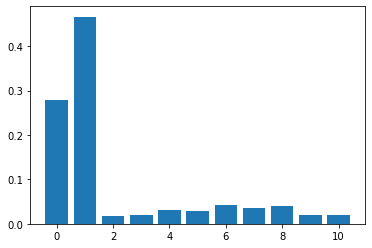

In [19]:
#Calculate the feature importance
importance = model_result.best_estimator_.feature_importances_

#Summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.2f' % (i,v))
    
#Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [20]:
display(df['last_session_creation_time'].corr(df['status']))
display(df['creation_time'].corr(df['status']))

0.40320994934811727

-0.09831205141840425

In [21]:
#Check for the important columns which have higher relation with the target
pd.DataFrame(model_result.best_estimator_.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
last_session_creation_time,0.466100
creation_time,0.279212
GUEST_INVITE,0.042459
PERSONAL_PROJECTS,0.039120
ORG_INVITE,0.034610
org_id,0.031007
invited_by_user_id,0.029201
SIGNUP,0.020774
enabled_for_marketing_drip,0.020268
SIGNUP_GOOGLE_AUTH,0.019637


# Conclusion

The XGBclassifier model has worked verry well for this problem with an accuracy of 98%. The most important features are `last_session_creation_time` and `creation_time`. The rest of the features have less than an order of magnitude smaller affect on the `status` based on the model.